Layer Normalization
=========================

Layer normalization was introduced by Jimmy Lei Ba, Jamie Ryan Kiros, and
Geoffery E. Hinton in their 2016 paper [Layer Normalization](https://arxiv.org/abs/1607.06450), but it only got really popular after being used in the hugely successful Transformer architecture.

Simply put: layer normalization standardizes individual data
points, not features. This is completely different than the standardizations we’ve performed so far. Before, each feature, either in the whole training set (using Scikit-learn's `StandardScaler` or in a mini-batch (using batch norm), was standardized to have zero mean and unit standard deviation. In a tabular dataset, we were standardizing the columns.

:::{important} Layer normalization
Layer normalization, in a tabular dataset, standardizes the rows. Each data point will have the average of its features equals zero, and the standard deviation of its features equals one.
:::

![batch vs. layer normalization](../images/batch_layer_norm.png)

## imports

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Positional Encoding

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

## Step-by-step Layer Normalization

- Calculating the mean of data point
- Calculating the standard deviation of the data point
- Computing the standardized data point


In [6]:
d_model = 4
seq_len = 2
n_points = 3

torch.manual_seed(34)
data = torch.randn(n_points, seq_len, d_model)
pe = PositionalEncoding(seq_len, d_model)
inputs = pe(data)
inputs

tensor([[[-3.8049,  1.9899, -1.7325,  2.1359],
         [ 1.7854,  0.8155,  0.1116, -1.7420]],

        [[-2.4273,  1.3559,  2.8615,  2.0084],
         [-1.0353, -1.2766, -2.2082, -0.6952]],

        [[-0.8044,  1.9707,  3.3704,  2.0587],
         [ 4.2256,  6.9575,  1.4770,  2.0762]]])

$$
\Large
\overline{X}_{n,l} = \frac{1}{D}\sum_{d=1}^Dx_{n,l,d}
$$

In [7]:
inputs_mean = inputs.mean(axis=2).unsqueeze(2)
inputs_mean

tensor([[[-0.3529],
         [ 0.2426]],

        [[ 0.9496],
         [-1.3038]],

        [[ 1.6489],
         [ 3.6841]]])

$$
\Large
\sigma_{n,l}(X) = \sqrt{\frac{1}{D}\sum_{d=1}^D(x_{n,l,d}-\overline{X}_{n,l})^2}
$$

In [8]:
inputs_var = inputs.var(axis=2, unbiased=False).unsqueeze(2)
inputs_var

tensor([[[6.3756],
         [1.6661]],

        [[4.0862],
         [0.3153]],

        [[2.3135],
         [4.6163]]])

$$
\Large
standardized\ x_{n,l,d}=\frac{x_{n,l,d}-\overline{X}_{n,l}}{\sigma_{n,l}(X) + \epsilon}
$$

In [9]:
(inputs - inputs_mean)/torch.sqrt(inputs_var+1e-5)

tensor([[[-1.3671,  0.9279, -0.5464,  0.9857],
         [ 1.1953,  0.4438, -0.1015, -1.5376]],

        [[-1.6706,  0.2010,  0.9458,  0.5238],
         [ 0.4782,  0.0485, -1.6106,  1.0839]],

        [[-1.6129,  0.2116,  1.1318,  0.2695],
         [ 0.2520,  1.5236, -1.0272, -0.7484]]])

In [11]:
layer_norm = nn.LayerNorm(d_model)
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

## PyTorch's `nn.LayerNorm` function

In [12]:
layer_norm = nn.LayerNorm(d_model)
normalized = layer_norm(inputs)

normalized[0][0].mean(), normalized[0][0].std(unbiased=False)

(tensor(-1.4901e-08, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<StdBackward>))

In [13]:
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

$$
\Large
layer\ normed\ x_{n,l,d} = b_d + w_d\ standardized\ x_{n,l,d}
$$

$$
\Large
layer\ normed\ x_{n,l,d} = standardized\ x_{n,l,d}\ \gamma_d + \beta_d
$$

## Layer Normalization of Positionally Encoded Dummy 

The size of the mini-batch strongly impacts the running statistics of the batch normalization. We also learned that batch norms oscillating statistics may introduce a regularizing effect.

None of this happens with layer normalization: it steadily delivers data points with
zero mean and unit standard deviation regardless of our choice of mini-batch size
or anything else. 

In [14]:
torch.manual_seed(23)
dummy_points = torch.randn(4, 1, 256)
dummy_pe = PositionalEncoding(1, 256)
dummy_enc = dummy_pe(dummy_points)
dummy_enc

tensor([[[-14.4193,  10.0495,  -7.8116,  ..., -15.4844, -18.0732,  -3.9566]],

        [[  2.6628,  -3.5462, -23.6461,  ...,  -0.9403, -18.4375, -37.4197]],

        [[-24.6397,  -1.9127, -16.4244,  ..., -17.3708, -26.0550, -14.0706]],

        [[ 13.7988,  21.4612,  10.4125,  ...,  -3.2333, -17.0188,   3.9237]]])

In [19]:
def hist_encoding(encoding):
    encoding = encoding.cpu().detach().numpy()
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    axs = axs.flatten()
    for i in range(4):
        data_point = encoding[i][0]
        axs[i].hist(data_point, bins=np.linspace(-3, 3, 15), alpha=.5)
        axs[i].set_xlabel(f'Data Point #{i}')
        axs[i].set_ylabel('# of features')
        axs[i].set_title(f'mean={data_point.mean():.4f}\n var={data_point.var():.4f}', fontsize=16)
        axs[i].set_ylim([0, 10])
        axs[i].label_outer()
    fig.tight_layout()    
    return fig

def hist_layer_normed(encoding, normed):
    encoding = encoding.cpu().detach().numpy()
    normed = normed.cpu().detach()
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for i in range(4):
        data_point = encoding[i][0]
        normed_point = normed.detach()[i][0]
        axs[i].hist(data_point, bins=np.linspace(-3, 3, 15), alpha=.5, label='Original')
        axs[i].hist(normed_point.numpy(), bins=np.linspace(-3, 3, 15), alpha=.5, label='Standardized')
        axs[i].set_xlabel(f'Data Point #{i}')
        axs[i].set_ylabel('# of features')
        axs[i].set_title(f'mean={normed.mean().numpy():.4f}\n std={normed.std(unbiased=False).numpy():.4f}', fontsize=16)
        axs[i].legend()
        axs[i].set_ylim([0, 80])
        axs[i].label_outer()
    fig.tight_layout()
    return fig



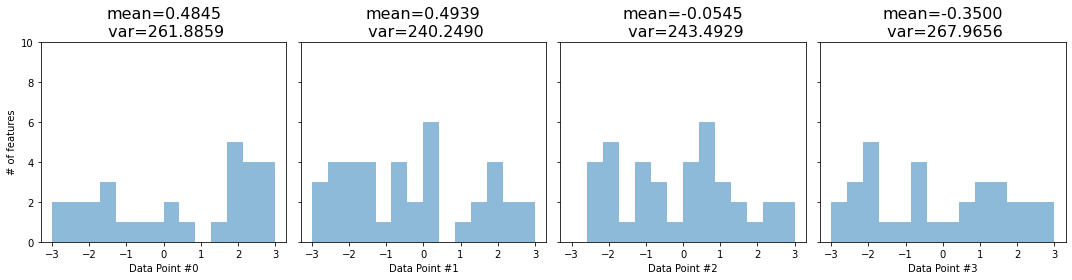

In [20]:
fig = hist_encoding(dummy_enc)

In [21]:
layer_normalizer = nn.LayerNorm(256)
dummy_normed = layer_normalizer(dummy_enc)
dummy_normed

tensor([[[-0.9210,  0.5911, -0.5127,  ..., -0.9868, -1.1467, -0.2744]],

        [[ 0.1399, -0.2607, -1.5574,  ..., -0.0925, -1.2214, -2.4460]],

        [[-1.5755, -0.1191, -1.0491,  ..., -1.1097, -1.6662, -0.8982]],

        [[ 0.8643,  1.3324,  0.6575,  ..., -0.1761, -1.0183,  0.2611]]],
       grad_fn=<NativeLayerNormBackward>)

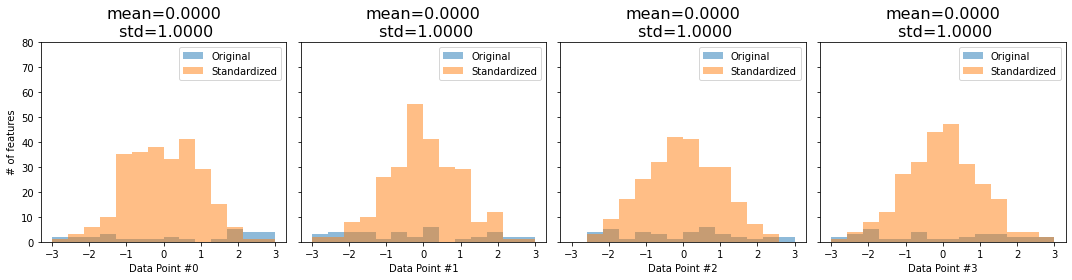

In [22]:
fig = hist_layer_normed(dummy_enc, dummy_normed)

## Our Seq2Seq Problem

So far, we have been using dummy examples to illustrate how layer normalization
works. Let's go back to our sequence-to-sequence problem, where the source
sequence had two data points, each data point representing the coordinates of
two corners. As usual, we are adding positional encoding to it

In [23]:
pe = PositionalEncoding(max_len=2, d_model=2)

source_seq = torch.tensor([[[ 1.0349,  0.9661], [ 0.8055, -0.9169]]])
source_seq_enc = pe(source_seq)
source_seq_enc

tensor([[[ 1.4636,  2.3663],
         [ 1.9806, -0.7564]]])

In [25]:
norm = nn.LayerNorm(2)
norm(source_seq_enc)

tensor([[[-1.0000,  1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward>)

:::{warning}
When one tries to layer normalize two features only: they become either minus one or one. Even worse, it will be the same for every data point. These
values will not get us anywhere. 
:::

We need projections (for numerical values) or embeddings (for categorical values) to get us from 2 dimensions to a different dimensionality.  

## Projections or Embeddings

:::{note}
Sometimes projections and embeddings are used
interchangeably. Here, we are sticking with embeddings
for categorical values and projections for numerical values.
}

Projections/Embeddings are referring to using a simple linear layer to project our pair of coordinates into a higher-dimensional feature space.

In [26]:
torch.manual_seed(11)
proj_dim = 6
linear_proj = nn.Linear(2, proj_dim)
pe = PositionalEncoding(2, proj_dim)

source_seq_proj = linear_proj(source_seq)
source_seq_proj_enc = pe(source_seq_proj)
source_seq_proj_enc

tensor([[[-2.0934,  1.5040,  1.8742,  0.0628,  0.3034,  2.0190],
         [-0.8853,  2.8213,  0.5911,  2.4193, -2.5230,  0.3599]]],
       grad_fn=<AddBackward0>)

In [27]:
norm = nn.LayerNorm(proj_dim)
norm(source_seq_proj_enc)

tensor([[[-1.9061,  0.6287,  0.8896, -0.3868, -0.2172,  0.9917],
         [-0.7362,  1.2864,  0.0694,  1.0670, -1.6299, -0.0568]]],
       grad_fn=<NativeLayerNormBackward>)